In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import os
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import hog
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [2]:
# Directory of the dataset
data_dir = '/kaggle/input/mango-leaf-disease-dataset'

# Get class names from the directory structure
class_names = os.listdir(data_dir)

# Prepare a list to store filenames and labels
data = []

# Iterate through each class folder to collect filenames and their labels
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):  # Check if it is a directory
        for filename in os.listdir(class_dir):
            if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust as needed
                data.append((os.path.join(class_name, filename), class_name))

# Create a DataFrame
df = pd.DataFrame(data, columns=['filename', 'label'])

# Show the first few rows of the DataFrame
print(df.head())


                                          filename           label
0  Powdery Mildew/IMG_20211107_124627 (Custom).jpg  Powdery Mildew
1  Powdery Mildew/IMG_20211107_125226 (Custom).jpg  Powdery Mildew
2  Powdery Mildew/IMG_20211107_125656 (Custom).jpg  Powdery Mildew
3  Powdery Mildew/IMG_20211107_125157 (Custom).jpg  Powdery Mildew
4      Powdery Mildew/20211109_121933 (Custom).jpg  Powdery Mildew


In [3]:
# Split the data into training and temp (validation + test)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])  # 70% train, 30% temp

# Split temp into validation and test
validation_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])  # 15% val, 15% test

# Print out the sizes of the splits
print(f"Training samples: {len(train_df)}, Validation samples: {len(validation_df)}, Testing samples: {len(test_df)}")


Training samples: 2800, Validation samples: 600, Testing samples: 600


In [4]:
# Create ImageDataGenerators for train, validation, and test
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values
    rotation_range=30,            # Randomly rotate images by up to 30 degrees
    horizontal_flip=True,         # Randomly flip images horizontally
    vertical_flip=True,           # Randomly flip images vertically
    fill_mode='nearest'           # Fill mode for missing pixels after transformations
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only normalization for validation
test_datagen = ImageDataGenerator(rescale=1./255) # Only normalization for testing

# Generators for training, validation, and test
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=data_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_dataframe(
    validation_df,
    directory=data_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=data_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 2800 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.


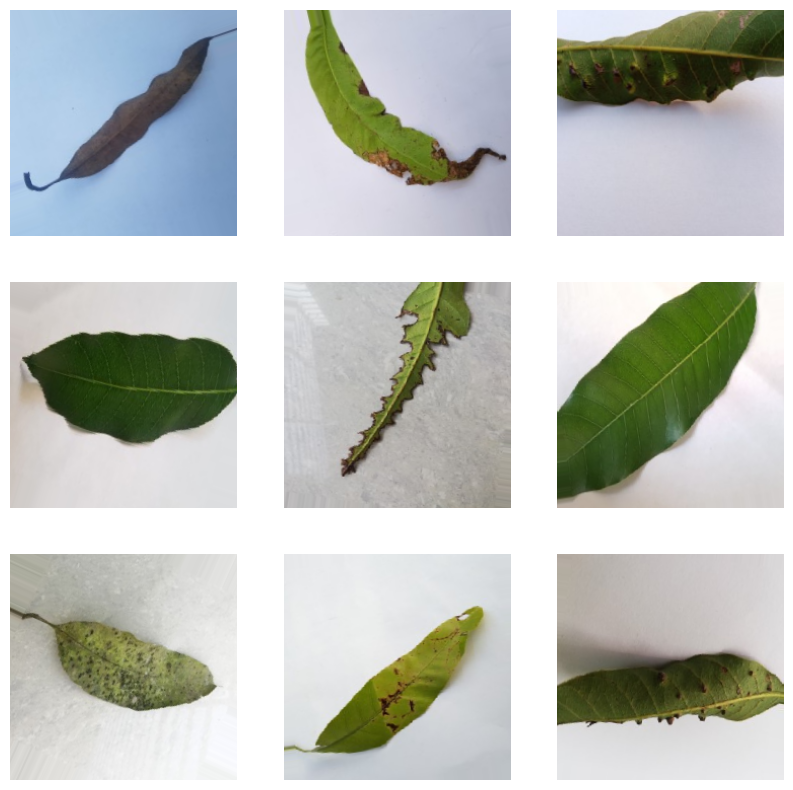

In [5]:
# Display 9 sample images from the batch
sample_batch = next(train_generator)  # Get one batch of training images
plt.figure(figsize=(10, 10))
for i in range(9):  # Display 9 images from the batch
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_batch[0][i])
    plt.axis('off')
plt.show()


In [6]:
# Function to extract HOG features from an image path
def extract_hog_features(image_path):
    image = imread(image_path)
    image_gray = rgb2gray(image)
    # Extract HOG features
    features = hog(image_gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=False)
    return features

# Function to extract and pad/truncate HOG features to a fixed length
def extract_and_pad_hog_features(image_filenames, data_dir, max_length=2916):
    hog_features = []
    for f in tqdm(image_filenames):
        features = extract_hog_features(os.path.join(data_dir, f))
        # Padding or truncating to ensure all feature vectors have the same length
        if len(features) < max_length:
            features = np.pad(features, (0, max_length - len(features)), 'constant')
        elif len(features) > max_length:
            features = features[:max_length]
        hog_features.append(features)
    return np.array(hog_features)


In [7]:
# Extract HOG features for training, validation, and test sets
train_features = extract_and_pad_hog_features(train_df['filename'], data_dir)
validation_features = extract_and_pad_hog_features(validation_df['filename'], data_dir)
test_features = extract_and_pad_hog_features(test_df['filename'], data_dir)

# Convert labels into numerical form
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['label'])
validation_labels = label_encoder.transform(validation_df['label'])
test_labels = label_encoder.transform(test_df['label'])


100%|██████████| 600/600 [00:12<00:00, 48.15it/s]


In [8]:
# Initialize and train Naive Bayes classifier
nb_classifier = GaussianNB()
nb_classifier.fit(train_features, train_labels)

# Predict on validation dataset and evaluate performance
validation_predictions = nb_classifier.predict(validation_features)
val_accuracy = accuracy_score(validation_labels, validation_predictions)
val_precision = precision_score(validation_labels, validation_predictions, average='macro')
val_recall = recall_score(validation_labels, validation_predictions, average='macro')
val_f1 = f1_score(validation_labels, validation_predictions, average='macro')

# Print validation results
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1-Score: {val_f1}")


Validation Accuracy: 0.5383333333333333
Validation Precision: 0.5216435222874786
Validation Recall: 0.5383333333333333
Validation F1-Score: 0.526470503169465


In [9]:
# Predict on test dataset and evaluate performance
test_predictions = nb_classifier.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions, average='macro')
test_recall = recall_score(test_labels, test_predictions, average='macro')
test_f1 = f1_score(test_labels, test_predictions, average='macro')

# Print test results
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1-Score: {test_f1}")


Test Accuracy: 0.48333333333333334
Test Precision: 0.464725431396175
Test Recall: 0.4833333333333333
Test F1-Score: 0.47014301773376677


In [10]:
# Function to train and evaluate a model
def train_and_evaluate(model, X_train, y_train, X_validation, y_validation):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on validation set
    y_pred = model.predict(X_validation)
    
    # Evaluate the model performance
    accuracy = accuracy_score(y_validation, y_pred)
    precision = precision_score(y_validation, y_pred, average='weighted')
    recall = recall_score(y_validation, y_pred, average='weighted')
    f1 = f1_score(y_validation, y_pred, average='weighted')
    
    # Return all evaluation metrics
    return accuracy, precision, recall, f1

In [11]:
# 1. SVM Model
svm_model = SVC(kernel='linear', random_state=42)

# Evaluate SVM using the train_and_evaluate function
svm_metrics = train_and_evaluate(svm_model, train_features, train_labels, validation_features, validation_labels)

# Display SVM results
print("SVM Metrics: Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1-Score: {:.2f}".format(*svm_metrics))


SVM Metrics: Accuracy: 0.72, Precision: 0.72, Recall: 0.72, F1-Score: 0.72


In [12]:
# 2. Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Evaluate Random Forest using the train_and_evaluate function
rf_metrics = train_and_evaluate(rf_model, train_features, train_labels, validation_features, validation_labels)

# Display Random Forest results
print("Random Forest Metrics: Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1-Score: {:.2f}".format(*rf_metrics))


Random Forest Metrics: Accuracy: 0.72, Precision: 0.71, Recall: 0.72, F1-Score: 0.71


In [13]:
# 3. K-Nearest Neighbors Model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Evaluate KNN using the train_and_evaluate function
knn_metrics = train_and_evaluate(knn_model, train_features, train_labels, validation_features, validation_labels)

# Display KNN results
print("KNN Metrics: Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1-Score: {:.2f}".format(*knn_metrics))


KNN Metrics: Accuracy: 0.59, Precision: 0.61, Recall: 0.59, F1-Score: 0.57


In [14]:
# Train Naive Bayes classifier on HOG features
nb_classifier.fit(train_features, train_labels)

# Evaluate Naive Bayes using the train_and_evaluate function
nb_metrics = train_and_evaluate(nb_classifier, train_features, train_labels, validation_features, validation_labels)

# Display Naive Bayes results
print("Naive Bayes Metrics: Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1-Score: {:.2f}".format(*nb_metrics))


Naive Bayes Metrics: Accuracy: 0.54, Precision: 0.52, Recall: 0.54, F1-Score: 0.53


In [15]:
# Summarize and compare metrics of different models
models = ['Naive Bayes', 'SVM', 'Random Forest', 'KNN']
metrics = [nb_metrics, svm_metrics, rf_metrics, knn_metrics]  # Include Naive Bayes metrics

# Display a comparison table
for i, model_name in enumerate(models):
    print(f"{model_name} Metrics: Accuracy: {metrics[i][0]:.2f}, Precision: {metrics[i][1]:.2f}, Recall: {metrics[i][2]:.2f}, F1-Score: {metrics[i][3]:.2f}")


Naive Bayes Metrics: Accuracy: 0.54, Precision: 0.52, Recall: 0.54, F1-Score: 0.53
SVM Metrics: Accuracy: 0.72, Precision: 0.72, Recall: 0.72, F1-Score: 0.72
Random Forest Metrics: Accuracy: 0.72, Precision: 0.71, Recall: 0.72, F1-Score: 0.71
KNN Metrics: Accuracy: 0.59, Precision: 0.61, Recall: 0.59, F1-Score: 0.57


## CNN Implementation

In [16]:
# Imports required for deep learning methods
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


In [18]:
# Define CNN model architecture
def create_basic_cnn(input_shape=(224, 224, 3), num_classes=len(train_generator.class_indices)):  # Use number of classes based on the dataset
    model = Sequential([
        Input(shape=input_shape),  # Use Input layer to define the input shape
        
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
    ])
    
    # Compile the model
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Initialize the CNN model
cnn_model = create_basic_cnn()

In [19]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = cnn_model.fit(
    train_generator,
    epochs=20,  # Can adjust based on performance
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732288216.728814      72 service.cc:145] XLA service 0x7e5d14005010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732288216.728881      72 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/88 ━━━━━━━━━━━━━━━━━━━━ 13:54 10s/step - accuracy: 0.0625 - loss: 2.1015

I0000 00:00:1732288222.109169      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 377ms/step - accuracy: 0.1922 - loss: 2.2406 - val_accuracy: 0.4517 - val_loss: 1.3659
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 333ms/step - accuracy: 0.4675 - loss: 1.4245 - val_accuracy: 0.6933 - val_loss: 0.8735
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 31s 324ms/step - accuracy: 0.6177 - loss: 1.0343 - val_accuracy: 0.7900 - val_loss: 0.6356
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 31s 325ms/step - accuracy: 0.7040 - loss: 0.7641 - val_accuracy: 0.6733 - val_loss: 0.8033
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 31s 328ms/step - accuracy: 0.7092 - loss: 0.7598 - val_accuracy: 0.9100 - val_loss: 0.3755
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 31s 329ms/step - accuracy: 0.8012 - loss: 0.5470 - val_accuracy: 0.9133 - val_loss: 0.3385
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 31s 329ms/step - accuracy: 0.8091 - loss: 0.5313 - val_accuracy: 0.9217 - val_loss: 0.3201
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 31s 327ms/step - accuracy: 0.8405 - loss: 0.4605 - val_accuracy: 0.905

In [20]:
# Evaluate on the test dataset
test_loss, test_accuracy = cnn_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Generate predictions
y_pred = cnn_model.predict(test_generator)
y_pred_labels = y_pred.argmax(axis=1)

# Get true labels from the test set
true_labels = test_generator.classes


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9590 - loss: 0.1206
Test Accuracy: 0.96
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


In [21]:
# Performance metrics
test_precision = precision_score(true_labels, y_pred_labels, average='macro')
test_recall = recall_score(true_labels, y_pred_labels, average='macro')
test_f1 = f1_score(true_labels, y_pred_labels, average='macro')

# Print classification report and metrics
print("Classification Report:\n", classification_report(true_labels, y_pred_labels, target_names=test_generator.class_indices.keys()))
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test F1-Score: {test_f1:.2f}")


Classification Report:
                   precision    recall  f1-score   support

     Anthracnose       0.99      0.96      0.97        75
Bacterial Canker       1.00      0.84      0.91        75
  Cutting Weevil       1.00      1.00      1.00        75
        Die Back       0.99      0.99      0.99        75
      Gall Midge       0.86      1.00      0.93        75
         Healthy       0.97      1.00      0.99        75
  Powdery Mildew       0.94      0.96      0.95        75
     Sooty Mould       0.95      0.92      0.93        75

        accuracy                           0.96       600
       macro avg       0.96      0.96      0.96       600
    weighted avg       0.96      0.96      0.96       600

Test Precision: 0.96
Test Recall: 0.96
Test F1-Score: 0.96


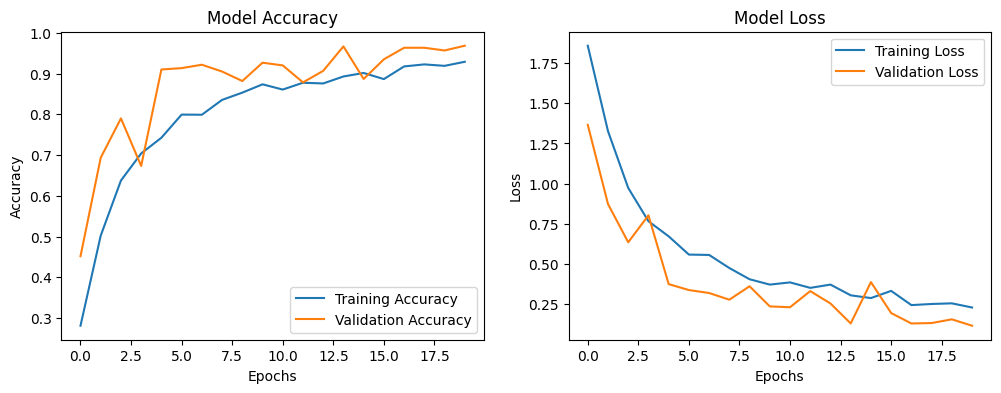

In [22]:
# Plotting training history (accuracy & loss)
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [23]:
# Save the trained model to a file
cnn_model.save('mango_leaf_disease_cnn.h5')  # Save as a .h5 file


## ResNet

Found 2800 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 53s 446ms/step - accuracy: 0.8013 - loss: 0.6357 - val_accuracy: 0.9833 - val_loss: 0.0317
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 334ms/step - accuracy: 0.9800 - loss: 0.0558 - val_accuracy: 0.9900 - val_loss: 0.0368
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 337ms/step - accuracy: 0.9889 - loss: 0.0389 - val_accuracy: 0.9933 - val_loss: 0.0165
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 338ms/step - accuracy: 0.9916 - loss: 0.0213 - val_accuracy: 0.9967 - val_loss: 0.0126
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 335ms/step - accuracy: 0.9886 - loss: 0.0319 - val_accuracy: 0.9900 - val_loss: 0.0326
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 339ms/step - accuracy: 0.9889 - loss: 0.0472 - val_accuracy: 0.9950 - val_loss: 0.0074
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 339ms/step - accuracy: 0.9889 - loss: 0.0298 - val_accuracy: 0.9933 - val_loss: 0.0205
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 339ms/step - accuracy: 0.9876 - loss: 0.0494 - val_accuracy: 0.988

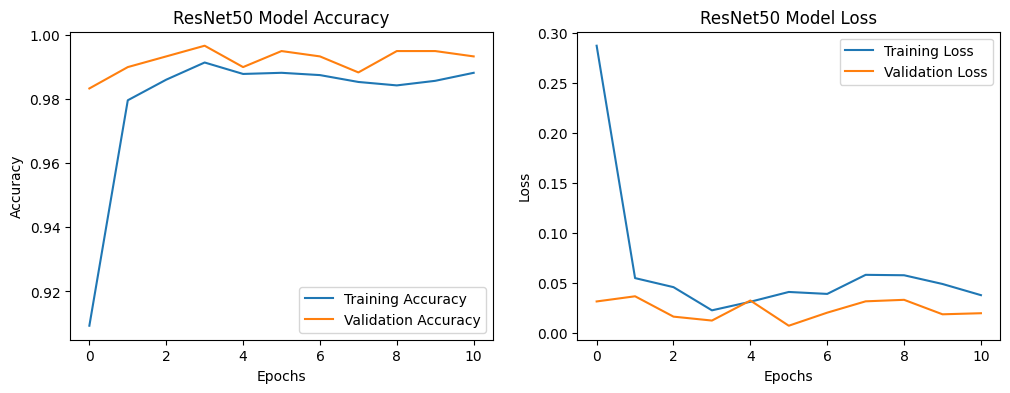

In [24]:
# Import required libraries
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Create ImageDataGenerators with ResNet50 preprocessing
train_datagen_resnet = ImageDataGenerator(
    preprocessing_function=resnet_preprocess_input,
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen_resnet = ImageDataGenerator(preprocessing_function=resnet_preprocess_input)
test_datagen_resnet = ImageDataGenerator(preprocessing_function=resnet_preprocess_input)

# Generators for training, validation, and test
train_generator_resnet = train_datagen_resnet.flow_from_dataframe(
    train_df,
    directory=data_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),  # ResNet50 input size
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator_resnet = val_datagen_resnet.flow_from_dataframe(
    validation_df,
    directory=data_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator_resnet = test_datagen_resnet.flow_from_dataframe(
    test_df,
    directory=data_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Define the ResNet50 model
def create_resnet50_model(input_shape=(224, 224, 3), num_classes=len(train_generator_resnet.class_indices)):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)  # Add a fully-connected layer
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Build the model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Initialize the ResNet50 model
resnet50_model = create_resnet50_model()

# Early stopping to prevent overfitting
early_stopping_resnet = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_resnet = resnet50_model.fit(
    train_generator_resnet,
    epochs=20,  # Adjust based on performance
    validation_data=validation_generator_resnet,
    callbacks=[early_stopping_resnet]
)

# Evaluate on the test dataset
test_loss_resnet, test_accuracy_resnet = resnet50_model.evaluate(test_generator_resnet)
print(f"ResNet50 Test Accuracy: {test_accuracy_resnet:.2f}")

# Generate predictions
y_pred_resnet = resnet50_model.predict(test_generator_resnet)
y_pred_labels_resnet = y_pred_resnet.argmax(axis=1)

# Get true labels from the test set
true_labels_resnet = test_generator_resnet.classes

# Performance metrics
test_precision_resnet = precision_score(true_labels_resnet, y_pred_labels_resnet, average='macro')
test_recall_resnet = recall_score(true_labels_resnet, y_pred_labels_resnet, average='macro')
test_f1_resnet = f1_score(true_labels_resnet, y_pred_labels_resnet, average='macro')

# Print classification report and metrics
print("ResNet50 Classification Report:\n", classification_report(true_labels_resnet, y_pred_labels_resnet, target_names=test_generator_resnet.class_indices.keys()))
print(f"ResNet50 Test Precision: {test_precision_resnet:.2f}")
print(f"ResNet50 Test Recall: {test_recall_resnet:.2f}")
print(f"ResNet50 Test F1-Score: {test_f1_resnet:.2f}")

# Plotting ResNet50 training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Save the trained ResNet50 model
resnet50_model.save('mango_leaf_disease_resnet50.h5')


## EfficientNet

Found 2800 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 91s 665ms/step - accuracy: 0.8014 - loss: 0.5443 - val_accuracy: 0.9833 - val_loss: 0.0603
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 34s 362ms/step - accuracy: 0.9738 - loss: 0.0761 - val_accuracy: 0.9833 - val_loss: 0.0525
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 35s 368ms/step - accuracy: 0.9775 - loss: 0.0697 - val_accuracy: 0.9917 - val_loss: 0.0283
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 35s 363ms/step - accuracy: 0.9914 - loss: 0.0294 - val_accuracy: 0.9833 - val_loss: 0.0406
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 35s 363ms/step - accuracy: 0.9839 - loss: 0.0484 - val_accuracy: 0.9867 - val_loss: 0.0356
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 34s 361ms/step - accuracy: 0.9833 - loss: 0.0499 - val_accuracy: 0.9767 - val_loss: 0.0693
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 34s 358ms/step - accuracy: 0.9774 - loss: 0.0648 - val_accuracy: 0.9933 - val_loss: 0.0240
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 34s 356ms/step - accuracy: 0.9844 - loss: 0.0439 - val_accuracy: 0.993

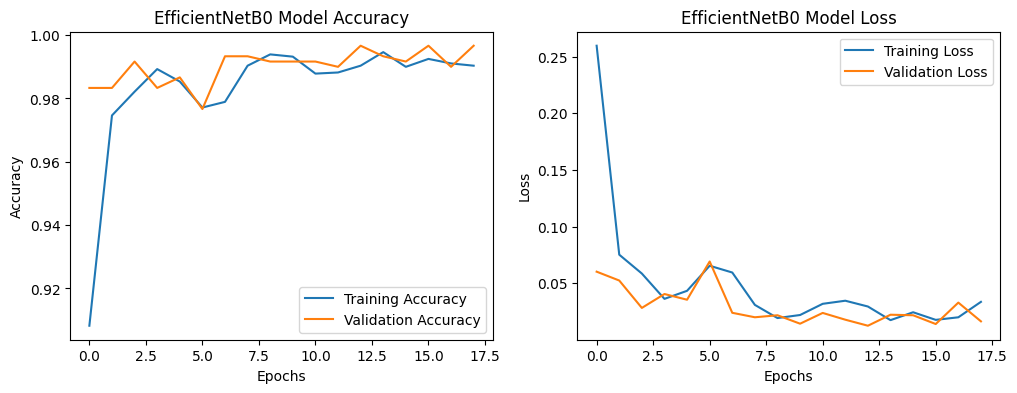

In [25]:
# Import required libraries
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input

# Create ImageDataGenerators with EfficientNetB0 preprocessing
train_datagen_effnet = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess_input,
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen_effnet = ImageDataGenerator(preprocessing_function=efficientnet_preprocess_input)
test_datagen_effnet = ImageDataGenerator(preprocessing_function=efficientnet_preprocess_input)

# Generators for training, validation, and test
train_generator_effnet = train_datagen_effnet.flow_from_dataframe(
    train_df,
    directory=data_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),  # EfficientNetB0 input size is 224x224
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator_effnet = val_datagen_effnet.flow_from_dataframe(
    validation_df,
    directory=data_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator_effnet = test_datagen_effnet.flow_from_dataframe(
    test_df,
    directory=data_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Define the EfficientNetB0 model
def create_efficientnetb0_model(input_shape=(224, 224, 3), num_classes=len(train_generator_effnet.class_indices)):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)  # Add a fully-connected layer
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Build the model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Initialize the EfficientNetB0 model
efficientnetb0_model = create_efficientnetb0_model()

# Early stopping to prevent overfitting
early_stopping_effnet = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_effnet = efficientnetb0_model.fit(
    train_generator_effnet,
    epochs=20,  # Adjust based on performance
    validation_data=validation_generator_effnet,
    callbacks=[early_stopping_effnet]
)

# Evaluate on the test dataset
test_loss_effnet, test_accuracy_effnet = efficientnetb0_model.evaluate(test_generator_effnet)
print(f"EfficientNetB0 Test Accuracy: {test_accuracy_effnet:.2f}")

# Generate predictions
y_pred_effnet = efficientnetb0_model.predict(test_generator_effnet)
y_pred_labels_effnet = y_pred_effnet.argmax(axis=1)

# Get true labels from the test set
true_labels_effnet = test_generator_effnet.classes

# Performance metrics
test_precision_effnet = precision_score(true_labels_effnet, y_pred_labels_effnet, average='macro')
test_recall_effnet = recall_score(true_labels_effnet, y_pred_labels_effnet, average='macro')
test_f1_effnet = f1_score(true_labels_effnet, y_pred_labels_effnet, average='macro')

# Print classification report and metrics
print("EfficientNetB0 Classification Report:\n", classification_report(true_labels_effnet, y_pred_labels_effnet, target_names=test_generator_effnet.class_indices.keys()))
print(f"EfficientNetB0 Test Precision: {test_precision_effnet:.2f}")
print(f"EfficientNetB0 Test Recall: {test_recall_effnet:.2f}")
print(f"EfficientNetB0 Test F1-Score: {test_f1_effnet:.2f}")

# Plotting EfficientNetB0 training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_effnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_effnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNetB0 Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_effnet.history['loss'], label='Training Loss')
plt.plot(history_effnet.history['val_loss'], label='Validation Loss')
plt.title('EfficientNetB0 Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Save the trained EfficientNetB0 model
efficientnetb0_model.save('mango_leaf_disease_efficientnetb0.h5')
